In [422]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.optimize import minimize
from typing import List

In [423]:
# define model (create class to avoid long parameter passing lists)
class Pipeline:
    def __init__(self, pipe_length, pipe_area, height):
        self.pipe_length = pipe_length
        self.pipe_area = pipe_area
        self.height = height
                
        self.drag_coefficient: float = 0.002
        self.flow_rate: float = 0
    
    def p_stat(self, fluid_density, gravity):
        return fluid_density * gravity * self.height
    
    def p_res(self, fluid_density):
        fluid_velocity = self.flow_rate / self.pipe_area
        return self.pipe_length * self.drag_coefficient * (fluid_density / 2) * fluid_velocity**2
    

class MultiPipelineModel:
    def __init__(self):
        self.p0: float = 1e6
        self.fluid_density: float = 1000
        self.gravity: float = 9.81
        self.power: float = 0

        self.pipelines: List[Pipeline] = []

        self.min_flow_rate: float = 0
        self.max_flow_rate: float = 2

        self.min_power = 200_000
        self.max_power = 1_000_000
    
    
    def flow_rate_pump(self):
        return sum(pipeline.flow_rate for pipeline in self.pipelines)
    
    def p_pump(self):
        pump_flow_rate = self.flow_rate_pump()
        a = 4/27 * (self.p0**3)/((self.power-1e5)**2)
        b = self.p0 / 2
        p_pump = self.p0 - a * pump_flow_rate**2 - b * pump_flow_rate**3
        return p_pump
    
    def differential_pressures(self):
        differential_pressures = []
        for pipeline in self.pipelines:
            dp = pipeline.p_stat(self.fluid_density, self.gravity) + pipeline.p_res(self.fluid_density) - self.p_pump()
            differential_pressures.append(dp)
        
        return differential_pressures
    
    def efficiency(self):
        if len(self.pipelines) != 1:
            raise Exception("Efficiency can only be determined with exactly one pipeline")
        
        return self.pipelines[0].p_stat(self.fluid_density, self.gravity) * self.flow_rate_pump() / self.power
    
    # solver functions
    def optimize_flow_rates(self):
        def root_function(x):
            for i, pipeline in enumerate(self.pipelines):
                pipeline.flow_rate = x[i]
            
            # create error scalar value
            return np.sum(np.power(self.differential_pressures(), 2))
        
        # get start values
        x0 = [pipeline.flow_rate for pipeline in self.pipelines]
        optimization = minimize(root_function, x0, method="Nelder-Mead")
        
        if not optimization.success:
            raise Exception("Flow rates did not converge")
        
        return optimization 

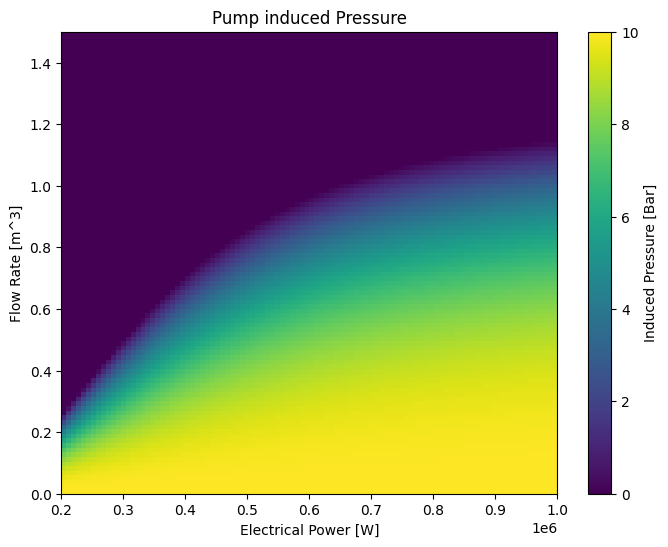

In [424]:
def plot_pump_characteristics():
    model = MultiPipelineModel()
    pipe1 = Pipeline(500, 0.05, 60)
    model.pipelines.append(pipe1)
    
    powers = np.linspace(model.min_power, model.max_power, 100)
    flow_rates = np.linspace(0, 1.5, 100)
    pressures = np.zeros((len(flow_rates), len(powers)))
    
    # calculate pressure for different flow rate and power combinations
    for i, flow_rate in enumerate(flow_rates):
        for j, power in enumerate(powers):
            model.power = power
            pipe1.flow_rate = flow_rate
            pressures[i, j] = model.p_pump()
    
    # clip values to zero
    pressures = np.clip(pressures, 0, None)
    
    # plot heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(pressures/100000, extent=(min(powers), max(powers), min(flow_rates), max(flow_rates)),
               aspect='auto', vmin=0, origin='lower')  # Set origin to 'lower'
    plt.colorbar(label='Induced Pressure [Bar]')
    plt.title("Pump induced Pressure")
    plt.xlabel("Electrical Power [W]")
    plt.ylabel("Flow Rate Pump [m^3]")
    plt.show()
    
plot_pump_characteristics()

<Figure size 800x600 with 0 Axes>

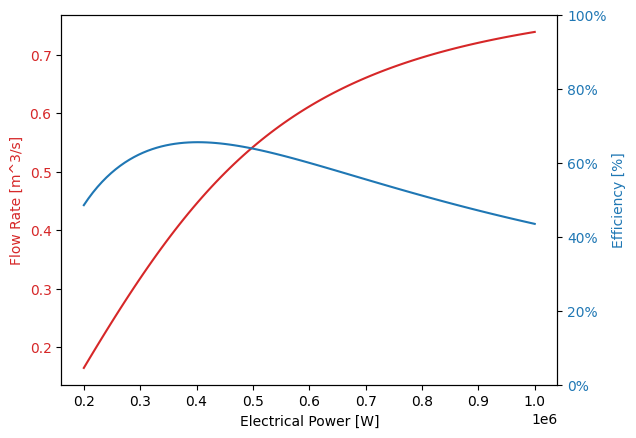

In [425]:
def plot_power_flow_rate_curve():
    model = MultiPipelineModel()
    pipe1 = Pipeline(500, 0.05, 60)
    model.pipelines.append(pipe1)
    
    powers = np.linspace(model.min_power, model.max_power, 100)
    flow_rates = np.zeros_like(powers)
    efficiencies = np.zeros_like(powers)
    
    for i, power in enumerate(powers):
        model.power = power
        model.optimize_flow_rates()
        flow_rates[i] = pipe1.flow_rate
        efficiencies[i] = model.efficiency()
        
    plt.figure(figsize=(8, 6))
    fig, ax1 = plt.subplots()
    
    fig.set_title("Single Pipe Model (L1=500, A1=0.05, H1=60)")
    
    color = 'tab:red'
    ax1.set_xlabel('Electrical Power [W]')
    ax1.set_ylabel('Flow Rate Pipe 1 [m^3/s]', color=color)
    ax1.plot(powers, flow_rates, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Efficiency [%]', color=color)
    ax2.plot(powers, efficiencies*100, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax2.set_ylim(0, 100)

    plt.show()
    
plot_power_flow_rate_curve()

In [426]:
def multi_pipeline_single_solve():
    # configure model
    model = MultiPipelineModel()
    model.power = 400_000
    
    pipe1 = Pipeline(500, 0.05, 60)
    model.pipelines.append(pipe1)

    pipe2 = Pipeline(2500, 0.03, 45)
    model.pipelines.append(pipe2)
    
    # optimize the flow rates to get a balanced system
    model.optimize_flow_rates()
    
    for pipeline in model.pipelines:
        print(pipeline.flow_rate)
        
    print(model.differential_pressures())
    
multi_pipeline_single_solve()

0.22445363720111178
0.2379103124769994
[-0.003662888309918344, -0.010760940262116492]


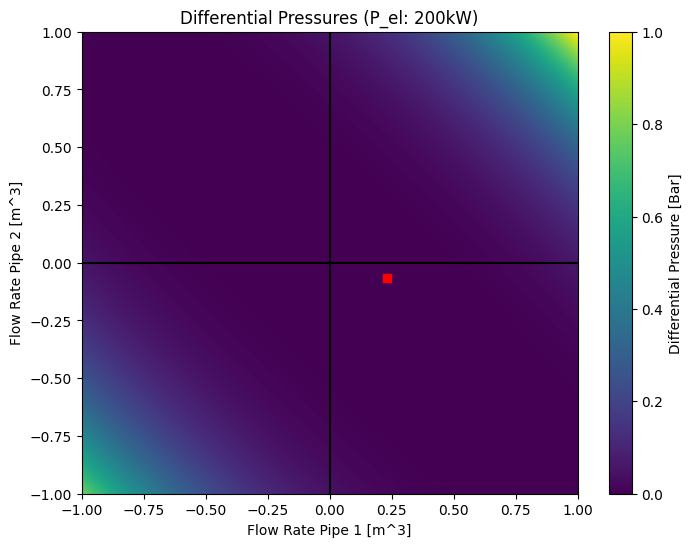

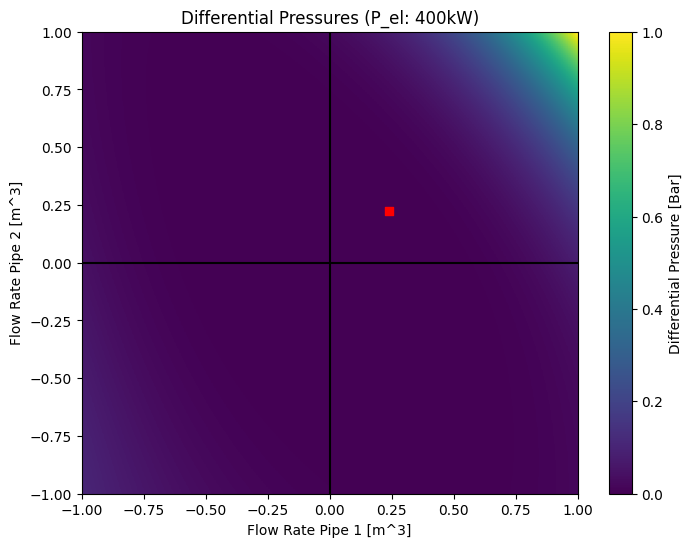

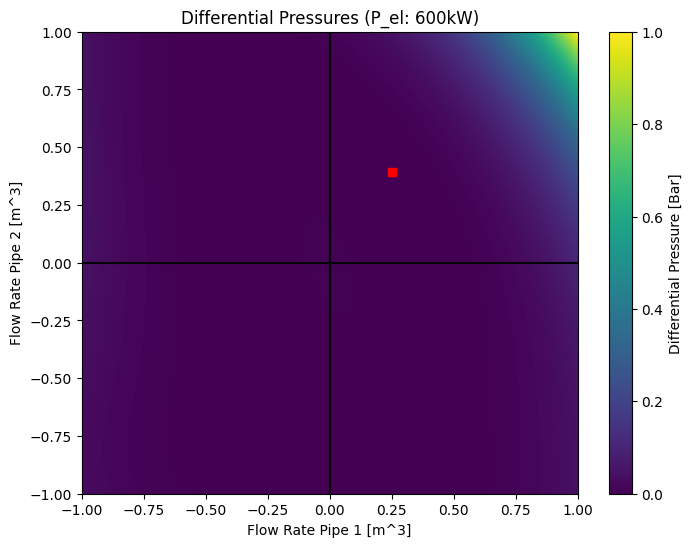

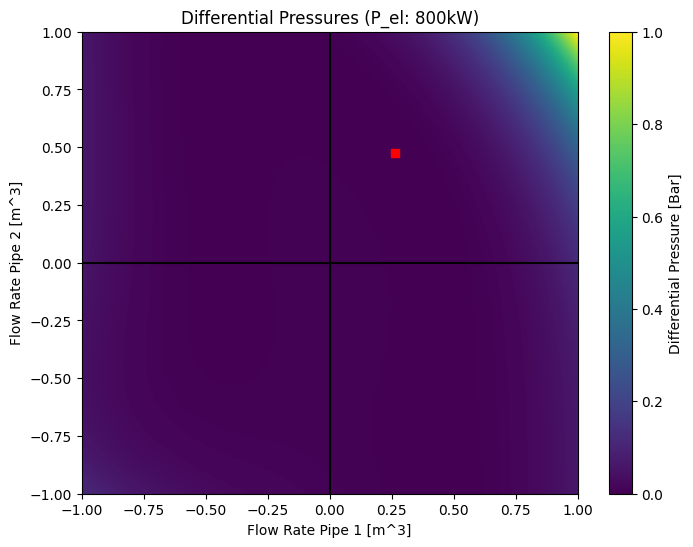

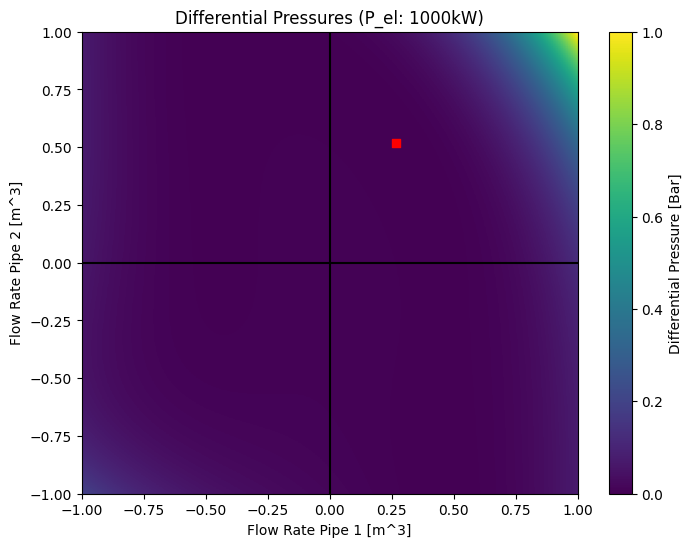

In [427]:
def plot_multi_pipeline_error_field():
    # configure model
    model = MultiPipelineModel()
    model.pipelines.append(Pipeline(500, 0.05, 60))
    model.pipelines.append(Pipeline(2500, 0.03, 45))
    
    powers = np.linspace(model.min_power, model.max_power, 5)
    
    for power in powers:
        model.power = power
        
        flow_rates_pipe1 = np.linspace(-1, 1, 200)
        flow_rates_pipe2 = np.linspace(-1, 1, 200)
        differential_pressures = np.zeros((len(flow_rates_pipe1), len(flow_rates_pipe2)))
        
        # calculate pressure for different flow rate and power combinations
        for i, frp1 in enumerate(flow_rates_pipe1):
            for j, frp2 in enumerate(flow_rates_pipe2):
                model.pipelines[0].flow_rate = frp1
                model.pipelines[1].flow_rate = frp2
                
                differential_pressure = np.sum(np.power(model.differential_pressures(), 2))
                differential_pressures[i, j] = differential_pressure
                
        # optimize the flow_rates for balance
        model.pipelines[0].flow_rate = 0
        model.pipelines[1].flow_rate = 0
        model.optimize_flow_rates()
            
        # plot
        plt.figure(figsize=(8, 6))
        plt.imshow(differential_pressures/100000, aspect='auto', vmin=0, origin='lower',
                   extent=(min(flow_rates_pipe1), max(flow_rates_pipe1), min(flow_rates_pipe2), max(flow_rates_pipe2)))
        
        # plot balance point
        plt.scatter(model.pipelines[1].flow_rate, model.pipelines[0].flow_rate, color='red', marker='s')
        
        plt.axhline(0, color='black')
        plt.axvline(0, color='black')

        plt.colorbar(label='Differential Pressure Map [Bar]')
        plt.title(f"Differential Pressures (P_el: {power/1000:.0f}kW)")
        plt.xlabel("Flow Rate Pipe 1 [m^3]")
        plt.ylabel("Flow Rate Pipe 2 [m^3]")
        plt.show()
    
plot_multi_pipeline_error_field()